In [1]:
# LB Score = 0.83793

# version 1.3
# Added Total damage feature

In [2]:
from scipy.sparse import hstack
import time
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler
import ujson as json
from tqdm import tqdm_notebook

In [3]:
def prepare_submit(model, x_test, file_name = 'submission'):
    y_test_pred= model.predict_proba(X_test)[:, 1]
    df_submission = pd.DataFrame({'radiant_win_prob': y_test_pred}, 
                                 index=df_test_features.index)
    df_submission.to_csv(file_name)

In [4]:
def train_model(X, X_test, y, params, folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None, silent = False):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        if (not silent) : print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.loc[train_index], X.loc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=20000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=1000,
                    early_stopping_rounds = 2000)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            
        
            
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))

        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:20].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 10));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores

In [5]:
train = pd.read_csv('../data/train_features.csv', index_col='match_id_hash')
target = pd.read_csv('../data/train_targets.csv', index_col='match_id_hash')
test = pd.read_csv('../data/test_features.csv', index_col='match_id_hash')

In [6]:
split_index = train.shape[0]

In [7]:
df = pd.concat([train, test], sort=False)

In [8]:
FE = pd.read_csv('FE.csv', index_col='match_id_hash')

In [9]:
df = pd.concat([df, FE], axis = 1)

In [10]:
items_damage = pd.read_csv('new_features.csv', index_col='match_id_hash')

In [11]:
df = pd.concat([df, items_damage], axis = 1)

In [12]:
hero_names = pd.read_csv('hero_names.csv', index_col='match_id_hash')
df = pd.concat([df, hero_names], axis = 1)

In [13]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

In [14]:
df.shape

(49675, 1072)

In [15]:
df = df.drop('r1_roshans_killed', axis = 1)
df = df.drop('r2_roshans_killed', axis = 1)
df = df.drop('r3_roshans_killed', axis = 1)
df = df.drop('r4_roshans_killed', axis = 1)
df = df.drop('r5_roshans_killed', axis = 1)

In [16]:
df = df.drop('d1_roshans_killed', axis = 1)
df = df.drop('d2_roshans_killed', axis = 1)
df = df.drop('d3_roshans_killed', axis = 1)
df = df.drop('d4_roshans_killed', axis = 1)
df = df.drop('d5_roshans_killed', axis = 1)

In [17]:
df.shape

(49675, 1062)

In [18]:
train = df[:split_index].copy()
test = df[split_index:].copy()

In [19]:
train = train.fillna(0)
test = test.fillna(0)

In [20]:
train.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d_hero_90,d_hero_91,d_hero_92,d_hero_93,d_hero_94,d_hero_95,d_hero_96,d_hero_97,d_hero_98,d_hero_99
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0,0,1,0,0,0,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,14,1,0,3,1,...,0,0,0,0,0,0,0,0,1,0
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,42,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
train['radiant_win'] = target['radiant_win']

Fold 0 started at Mon Oct 14 02:00:22 2019
Training until validation scores don't improve for 2000 rounds
[1000]	training's auc: 0.892575	valid_1's auc: 0.836499
[2000]	training's auc: 0.938488	valid_1's auc: 0.842934
[3000]	training's auc: 0.966249	valid_1's auc: 0.845429
[4000]	training's auc: 0.982846	valid_1's auc: 0.846239
[5000]	training's auc: 0.992316	valid_1's auc: 0.846294
[6000]	training's auc: 0.996995	valid_1's auc: 0.846293
[7000]	training's auc: 0.998988	valid_1's auc: 0.846119
Early stopping, best iteration is:
[5850]	training's auc: 0.996501	valid_1's auc: 0.846392
Fold 1 started at Mon Oct 14 02:01:19 2019
Training until validation scores don't improve for 2000 rounds
[1000]	training's auc: 0.894396	valid_1's auc: 0.824629
[2000]	training's auc: 0.939795	valid_1's auc: 0.832208
[3000]	training's auc: 0.966998	valid_1's auc: 0.83493
[4000]	training's auc: 0.983436	valid_1's auc: 0.835651
[5000]	training's auc: 0.992674	valid_1's auc: 0.835963
[6000]	training's auc: 0.9

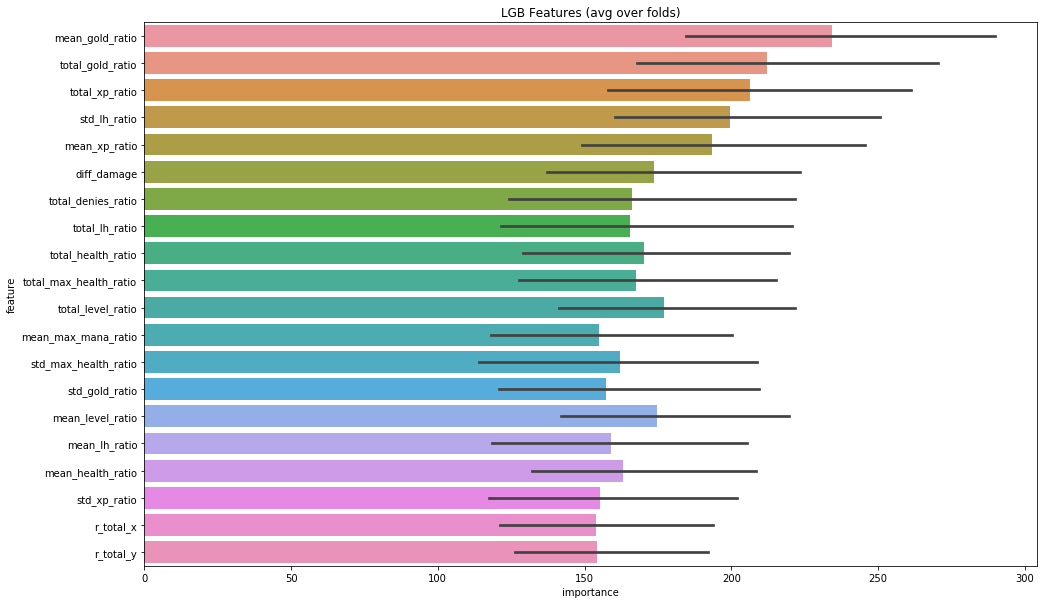

In [22]:
params = {'boost': 'gbdt',
          'feature_fraction': 0.05,
          'learning_rate': 0.01,
          'max_depth': -1,  
          'metric':'auc',
          'min_data_in_leaf': 50,
          'num_leaves': 32,
          'num_threads': -1,
          'verbosity': 1,
          'objective': 'binary'
         }

X = train.drop(['radiant_win'], axis=1).reset_index(drop=True)
y = target['radiant_win']
X_test = test.reset_index(drop=True)

oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True, silent = False)

In [23]:
prediction_lgb

array([0.26911904, 0.99513598, 0.98309275, ..., 0.47299334, 0.83108504,
       0.04866193])

In [24]:
df_submission = pd.DataFrame({'radiant_win_prob': prediction_lgb}, 
                                 index=test.index)
df_submission.to_csv('Submission6_EF_items_damage_names.csv')

In [25]:
# CV mean score: 0.8290, std: 0.0049

In [26]:
test.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d_hero_90,d_hero_91,d_hero_92,d_hero_93,d_hero_94,d_hero_95,d_hero_96,d_hero_97,d_hero_98,d_hero_99
match_id_hash,,,,,,,,,,,,,,,,,,,,,
30cc2d778dca82f2edb568ce9b585caa,23,4,0,0,0,79,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
70e5ba30f367cea48793b9003fab9d38,1044,22,7,12,6,23,3,5,7,1,...,0,0,0,0,0,1,0,0,0,1
4d9ef74d3a2025d79e9423105fd73d41,1091,22,7,6,1,64,3,1,7,1,...,0,0,0,0,0,0,0,0,0,0
2bb79e0c1eaac1608e5a09c8e0c6a555,623,22,7,1,0,41,0,0,1,2,...,0,0,0,0,0,0,0,1,1,0
bec17f099b01d67edc82dfb5ce735a43,1538,22,7,7,11,40,2,7,12,0,...,0,0,0,0,0,0,0,0,0,0


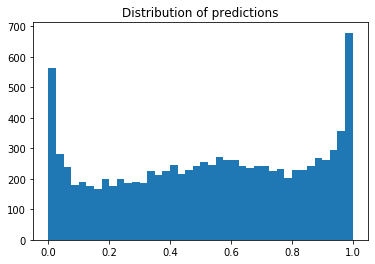

In [27]:
plt.hist(prediction_lgb, bins=40);
plt.title('Distribution of predictions');